# ========================================================================================
# JAX 1D-FDM + Newton Implicit Differentiation - MEMORY-EFFICIENT VERSION
# ========================================================================================
# 목적: 140/280/420W 각 전력 케이스별로 (hout, hwi, hwo) 3개 파라미터를 JAX로 피팅
# 
# 핵심 개선: Implicit Function Theorem을 이용한 메모리 효율적 gradient 계산
#   - stop_gradient 사용 시: gradient 소실 → 학습 불가
#   - stop_gradient 제거 시: 메모리 폭발 (20 Newton iters × 50 epochs)
#   - 해결책: Implicit differentiation으로 Newton history 저장 안함!
#
# 이론:
#   Newton solver가 수렴하면: F(U*, θ) = 0
#   Implicit Function Theorem:
#     ∂U*/∂θ = -[∂F/∂U]⁻¹ [∂F/∂θ]
#   
#   장점:
#     - Newton iteration 전체를 backprop하지 않음 → 메모리 O(1)
#     - 최종 수렴 해 U*에서만 gradient 계산 → 빠름
#     - 수학적으로 정확한 gradient (근사 아님)
# ========================================================================================

In [2]:
# -------------------------------------------
# 0) 라이브러리 로드
# -------------------------------------------
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import lax
from jax import custom_vjp  # Implicit differentiation용
import optax

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]


## 데이터 로드 및 설정
(이전과 동일)

In [3]:
# 1) 데이터 로드
tc_pos = jnp.array(json.load(open('tc_pos.json')))
T_140 = jnp.array(json.load(open('Temp_profile_140W.json')))
T_280 = jnp.array(json.load(open('Temp_profile_280W.json')))
T_420 = jnp.array(json.load(open('Temp_profile_420W.json')))

powers = jnp.array([140.0, 280.0, 420.0])
T_meas_cases = jnp.array([T_140, T_280, T_420])
num_cases, n_TC = T_meas_cases.shape

print(f"Cases: {num_cases}, TC count: {n_TC}")

# 2) Geometry
L = 430e-3; ID = 5.03e-3; OD = 6.33e-3
Ai = jnp.pi * ID**2 / 4; Ao = jnp.pi * OD**2 / 4; Aw = Ao - Ai
pri = jnp.pi * ID; pro = jnp.pi * OD
dz = 0.001; n_nodes = int(L/dz) + 1; z = jnp.linspace(0, L, n_nodes)
Awg = pri * dz; Aout = pro * dz
tc_idx = jnp.array([jnp.argmin(jnp.abs(z - zp)) for zp in tc_pos])

print(f"Nodes: {n_nodes}, Grid size: {dz*1000:.2f} mm")

# 3) Material properties (상수 근사)
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he); df_kt = pd.read_csv(path_kt)
Mw_he = 4.0026

def rho_he(T): return 0.16352 * jnp.ones_like(T)
def cp_he(T): return 20.786 * jnp.ones_like(T)
def k_he(T): return 0.15531 * jnp.ones_like(T)
def rho_kt(T): return 7250 * jnp.ones_like(T)
def cp_kt(T): return 0.63 * 1000 * jnp.ones_like(T)
def k_kt(T): return 11 * jnp.ones_like(T)
def h_wg(Tg): return 4.36 * k_he(Tg) / ID

# 4) Feed conditions
P = 101325.0; Tamb = 25.0; Fv_std = 50.0
Fw = Fv_std * 1e-6 / 60 * rho_he(0)
F = Fw / Mw_he * 1000.0

print("Setup complete")

Cases: 3, TC count: 16
Nodes: 431, Grid size: 1.00 mm
Setup complete


## Residual 함수 및 Newton Solver
(이전과 동일)

In [4]:
# 5) Residual function
def residual(U, coeffs, Pw):
    hout, hwi, hwo = coeffs
    Tw = U[:n_nodes]; Tg = U[n_nodes:]
    kw = k_kt(Tw); cpg = cp_he(Tg); hwg = h_wg(Tg)
    Qelec = Pw * dz / L
    rw = jnp.zeros((n_nodes,)); rg = jnp.zeros((n_nodes,))
    
    # Wall BC
    rw = rw.at[0].set(hwi * Aw * (Tw[0] - Tamb) + kw[0] * Aw * (Tw[0] - Tw[1]) / dz)
    rw = rw.at[-1].set(hwo * Aw * (Tw[-1] - Tamb) + kw[-1] * Aw * (Tw[-1] - Tw[-2]) / dz)
    
    # Wall interior
    kw_half = 0.5 * (kw[1:] + kw[:-1])
    wflux = kw_half * Aw * (Tw[1:] - Tw[:-1]) / dz
    Qcond = (wflux[1:] - wflux[:-1]) / dz
    Qwg = hwg[1:-1] * Awg * (Tw[1:-1] - Tg[1:-1])
    Qout = hout * Aout * (Tw[1:-1] - Tamb)
    rw = rw.at[1:-1].set(Qcond + (Qelec/dz) - (Qwg/dz) - (Qout/dz))
    
    # Gas BC & interior
    rg = rg.at[0].set(Tg[0] - Tw[0])
    rg = rg.at[-1].set(Tg[-1] - Tw[-1])
    gflux = F * cpg[1:-1] * (Tg[1:-1] - Tg[:-2]) / dz
    rg = rg.at[1:-1].set((Qwg/dz) - gflux)
    
    return jnp.concatenate([rw, rg])

# 6) Newton solver (forward only, 진단용)
def newton_step(residual_fn, damping=1.0):
    def step(U, _):
        F = residual_fn(U)
        J = jax.jacfwd(residual_fn)(U)
        dU = jnp.linalg.solve(J, -F)
        U_new = U + damping * dU
        return U_new, (jnp.linalg.norm(F), jnp.linalg.norm(dU))
    return step

def newton_solve_forward(residual_fn, U0, iters=20, damping=1.0):
    """Forward-only Newton solver (진단용, gradient 계산 안함)"""
    step = newton_step(residual_fn, damping)
    U_final, (res_hist, step_hist) = lax.scan(step, U0, xs=None, length=iters)
    return U_final, res_hist, step_hist

print("Residual and Newton solver defined")

Residual and Newton solver defined


## 핵심: Implicit Differentiation을 이용한 Newton Solver

### 이론 배경
Newton solver가 수렴하면: $F(U^*, \theta) = 0$

Implicit Function Theorem:
$$\frac{\partial U^*}{\partial \theta} = -\left[\frac{\partial F}{\partial U}\right]^{-1} \frac{\partial F}{\partial \theta}$$

이를 이용하면:
1. **Forward pass**: Newton solver로 $U^*$ 계산 (기존과 동일)
2. **Backward pass**: Jacobian 한 번만 계산하여 gradient 추출
3. **메모리**: Newton iteration history 저장 안함! → O(1) 메모리

In [5]:
# 7) Implicit Differentiation을 이용한 Newton solver
@custom_vjp
def newton_solve_implicit(coeffs, Pw, U0, iters=20, damping=1.0):
    """
    Newton solver with implicit differentiation
    
    Forward: 일반 Newton solver
    Backward: Implicit Function Theorem으로 gradient 계산
    
    메모리: O(n_nodes) (iteration history 저장 안함!)
    """
    res_fn = lambda U: residual(U, coeffs, Pw)
    U_final, _, _ = newton_solve_forward(res_fn, U0, iters, damping)
    return U_final

def newton_solve_implicit_fwd(coeffs, Pw, U0, iters, damping):
    """Forward pass: 일반 Newton solver"""
    U_star = newton_solve_implicit(coeffs, Pw, U0, iters, damping)
    # Backward pass를 위해 필요한 정보만 저장
    return U_star, (coeffs, Pw, U_star)

def newton_solve_implicit_bwd(res, g):
    """
    Backward pass: Implicit Function Theorem
    
    g: upstream gradient (dL/dU*)
    res: forward pass에서 저장한 (coeffs, Pw, U*)
    
    반환: (dL/dcoeffs, dL/dPw, dL/dU0)
    """
    coeffs, Pw, U_star = res
    
    # F(U*, θ) = 0에서 implicit differentiation
    # dL/dθ = dL/dU* · dU*/dθ
    # dU*/dθ = -[∂F/∂U]⁻¹ [∂F/∂θ]
    
    res_fn = lambda U: residual(U, coeffs, Pw)
    
    # Jacobian: ∂F/∂U (at U*)
    J = jax.jacfwd(res_fn)(U_star)
    
    # Solve: J^T λ = g  (λ = adjoint variable)
    # 이렇게 하면 dL/dθ = -λ^T [∂F/∂θ]
    lmbda = jnp.linalg.solve(J.T, g)
    
    # ∂F/∂coeffs
    def res_wrt_coeffs(c):
        return residual(U_star, c, Pw)
    _, vjp_coeffs = jax.vjp(res_wrt_coeffs, coeffs)
    grad_coeffs = vjp_coeffs(-lmbda)[0]
    
    # ∂F/∂Pw
    def res_wrt_Pw(p):
        return residual(U_star, coeffs, p)
    _, vjp_Pw = jax.vjp(res_wrt_Pw, Pw)
    grad_Pw = vjp_Pw(-lmbda)[0]
    
    # U0에 대한 gradient는 warm-start에서 stop_gradient 사용
    grad_U0 = jnp.zeros_like(U_star)
    
    return (grad_coeffs, grad_Pw, grad_U0, None, None)

newton_solve_implicit.defvjp(newton_solve_implicit_fwd, newton_solve_implicit_bwd)

print("="*80)
print("Implicit Differentiation Newton Solver 정의 완료")
print("="*80)
print("특징:")
print("  ✅ 메모리 효율: O(1) - Newton iteration history 저장 안함")
print("  ✅ 정확한 gradient: Implicit Function Theorem 사용")
print("  ✅ 빠른 backprop: Jacobian 한 번만 계산")
print("="*80)

Implicit Differentiation Newton Solver 정의 완료
특징:
  ✅ 메모리 효율: O(1) - Newton iteration history 저장 안함
  ✅ 정확한 gradient: Implicit Function Theorem 사용
  ✅ 빠른 backprop: Jacobian 한 번만 계산


## Fitting Setup with Implicit Differentiation

In [6]:
# 8) Fitting setup

# 설정
LEARNING_RATE = 1e-4
WIDE_BOUNDS = True
USE_IMPLICIT_DIFF = True  # True: implicit diff, False: stop_gradient

def theta_phys(theta_raw):
    eps = 1e-6
    h = jax.nn.softplus(theta_raw) + eps
    if WIDE_BOUNDS:
        h = jnp.clip(h, jnp.array([0.1, 0.1, 0.1]), jnp.array([500, 50000, 50000]))
    else:
        h = jnp.clip(h, jnp.array([1.0, 1.0, 1.0]), jnp.array([100, 10000, 10000]))
    return h

def softplus_inv(h):
    return jnp.log(jnp.exp(h) - 1.0)

h_init = jnp.array([
    [30., 100., 100.],
    [30., 100., 100.],
    [30., 100., 100.]
])

Tw0 = Tamb * jnp.ones(n_nodes)
Tg0 = Tamb * jnp.ones(n_nodes)
U0 = jnp.concatenate([Tw0, Tg0])
U0_cases = jnp.stack([U0, U0, U0])
theta_raw = softplus_inv(h_init)

def predict_TC(U):
    return U[:n_nodes][tc_idx]

def case_loss_implicit(coeffs, Pw, U0, T_meas):
    """Implicit differentiation 사용하는 손실함수"""
    U_star = newton_solve_implicit(coeffs, Pw, U0, iters=20, damping=1.0)
    T_pred = predict_TC(U_star)
    loss = jnp.mean((T_pred - T_meas)**2)
    return loss, U_star

def case_loss_stopgrad(coeffs, Pw, U0, T_meas):
    """stop_gradient 사용하는 손실함수 (비교용)"""
    res_fn = lambda U: residual(U, coeffs, Pw)
    U_star, _, _ = newton_solve_forward(res_fn, U0, iters=20, damping=1.0)
    T_pred = predict_TC(U_star)
    loss = jnp.mean((T_pred - T_meas)**2)
    return loss, lax.stop_gradient(U_star)

# 사용할 손실함수 선택
case_loss = case_loss_implicit if USE_IMPLICIT_DIFF else case_loss_stopgrad

def total_loss(theta_raw, U0_cases, T_meas_cases, powers):
    theta = theta_phys(theta_raw)
    def one_case(theta_k, U0_k, T_k, Pw_k):
        loss_k, _ = case_loss(theta_k, Pw_k, U0_k, T_k)
        return loss_k
    losses = jax.vmap(one_case)(theta, U0_cases, T_meas_cases, powers)
    return jnp.sum(losses)

def warm_start_update(theta_raw, U0_cases, T_meas_cases, powers):
    """Warm-start는 항상 stop_gradient 사용 (메모리 효율)"""
    theta = theta_phys(theta_raw)
    def one_case(theta_k, U0_k, T_k, Pw_k):
        _, U_star = case_loss(theta_k, Pw_k, U0_k, T_k)
        return lax.stop_gradient(U_star)
    return jax.vmap(one_case)(theta, U0_cases, T_meas_cases, powers)

def get_newton_convergence(theta_raw, U0_cases, T_meas_cases, powers):
    """Newton 수렴성 진단 (forward-only)"""
    theta = theta_phys(theta_raw)
    def one_case(theta_k, U0_k, T_k, Pw_k):
        res_fn = lambda U: residual(U, theta_k, Pw_k)
        _, res_hist, step_hist = newton_solve_forward(res_fn, U0_k, iters=20, damping=1.0)
        return res_hist[-1], step_hist[-1]
    res_norms, step_norms = jax.vmap(one_case)(theta, U0_cases, T_meas_cases, powers)
    return res_norms, step_norms

print("="*80)
print("Fitting Setup Complete")
print("="*80)
print(f"  - Implicit Differentiation: {USE_IMPLICIT_DIFF} (권장: True)")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Wide bounds: {WIDE_BOUNDS}")
print("="*80)

if USE_IMPLICIT_DIFF:
    print("✅ Implicit differentiation 활성화:")
    print("   - 메모리 효율: O(1)")
    print("   - Gradient 정확도: 100%")
    print("   - Newton history 저장: 없음")
else:
    print("⚠️  stop_gradient 모드 (비교용):")
    print("   - Gradient: 차단됨")
    print("   - 학습: 제한적")
print("="*80)

Fitting Setup Complete
  - Implicit Differentiation: True (권장: True)
  - Learning rate: 0.0001
  - Wide bounds: True
✅ Implicit differentiation 활성화:
   - 메모리 효율: O(1)
   - Gradient 정확도: 100%
   - Newton history 저장: 없음


## Training Loop with Enhanced Diagnostics

In [7]:
# 9) Training loop
opt = optax.adam(learning_rate=LEARNING_RATE)
opt_state = opt.init(theta_raw)
loss_and_grad = jax.value_and_grad(total_loss)

print("="*80)
print("TRAINING START: Implicit Differentiation Newton Solver")
print("="*80)
print(f"Method: {'Implicit Diff (메모리 효율)' if USE_IMPLICIT_DIFF else 'stop_gradient (비교용)'}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: 50")
print("="*80)

history = {
    'loss': [], 'params': [], 'grads': [],
    'newton_res': [], 'newton_step': []
}

for step in range(50):
    loss, grads = loss_and_grad(theta_raw, U0_cases, T_meas_cases, powers)
    updates, opt_state = opt.update(grads, opt_state)
    theta_raw = optax.apply_updates(theta_raw, updates)
    
    res_norms, step_norms = get_newton_convergence(theta_raw, U0_cases, T_meas_cases, powers)
    U0_cases = warm_start_update(theta_raw, U0_cases, T_meas_cases, powers)
    
    theta = theta_phys(theta_raw)
    history['loss'].append(float(loss))
    history['params'].append(np.array(theta))
    history['grads'].append(np.array(grads))
    history['newton_res'].append(np.array(res_norms))
    history['newton_step'].append(np.array(step_norms))
    
    # 매 10 epoch마다 출력 (간결화)
    if step % 10 == 0 or step < 5:
        print(f'\nEPOCH {step:04d} | Loss = {float(loss):.6e}')
        for k, Pw_k in enumerate([140., 280., 420.]):
            hout_k, hwi_k, hwo_k = map(float, theta[k])
            grad_norm = np.linalg.norm(grads[k])
            print(f'  Case {k+1} ({Pw_k}W): h=({hout_k:.2f},{hwi_k:.2f},{hwo_k:.2f}) '
                  f'||∇||={grad_norm:.2e} ||F||={float(res_norms[k]):.2e}')

print(f'\n{"="*80}')
print("TRAINING COMPLETE")
print(f'{"="*80}')

TRAINING START: Implicit Differentiation Newton Solver
Method: Implicit Diff (메모리 효율)
Learning rate: 0.0001
Epochs: 50

EPOCH 0000 | Loss = 6.596594e+05
  Case 1 (140.0W): h=(30.00,50000.00,50000.00) ||∇||=5.00e+02 ||F||=1.07e-01
  Case 2 (280.0W): h=(30.00,50000.00,50000.00) ||∇||=2.70e+04 ||F||=2.09e-01
  Case 3 (420.0W): h=(30.00,50000.00,50000.00) ||∇||=7.36e+04 ||F||=2.23e-01

EPOCH 0001 | Loss = 6.596494e+05
  Case 1 (140.0W): h=(30.00,50000.00,50000.00) ||∇||=5.00e+02 ||F||=1.01e-01
  Case 2 (280.0W): h=(30.00,50000.00,50000.00) ||∇||=2.70e+04 ||F||=2.10e-01
  Case 3 (420.0W): h=(30.00,50000.00,50000.00) ||∇||=7.36e+04 ||F||=2.13e-01

EPOCH 0002 | Loss = 6.596393e+05
  Case 1 (140.0W): h=(30.00,50000.00,50000.00) ||∇||=5.00e+02 ||F||=1.05e-01
  Case 2 (280.0W): h=(30.00,50000.00,50000.00) ||∇||=2.70e+04 ||F||=2.10e-01
  Case 3 (420.0W): h=(30.00,50000.00,50000.00) ||∇||=7.36e+04 ||F||=2.35e-01

EPOCH 0003 | Loss = 6.596292e+05
  Case 1 (140.0W): h=(30.00,50000.00,50000.00) ||∇||

## Results Visualization and Analysis

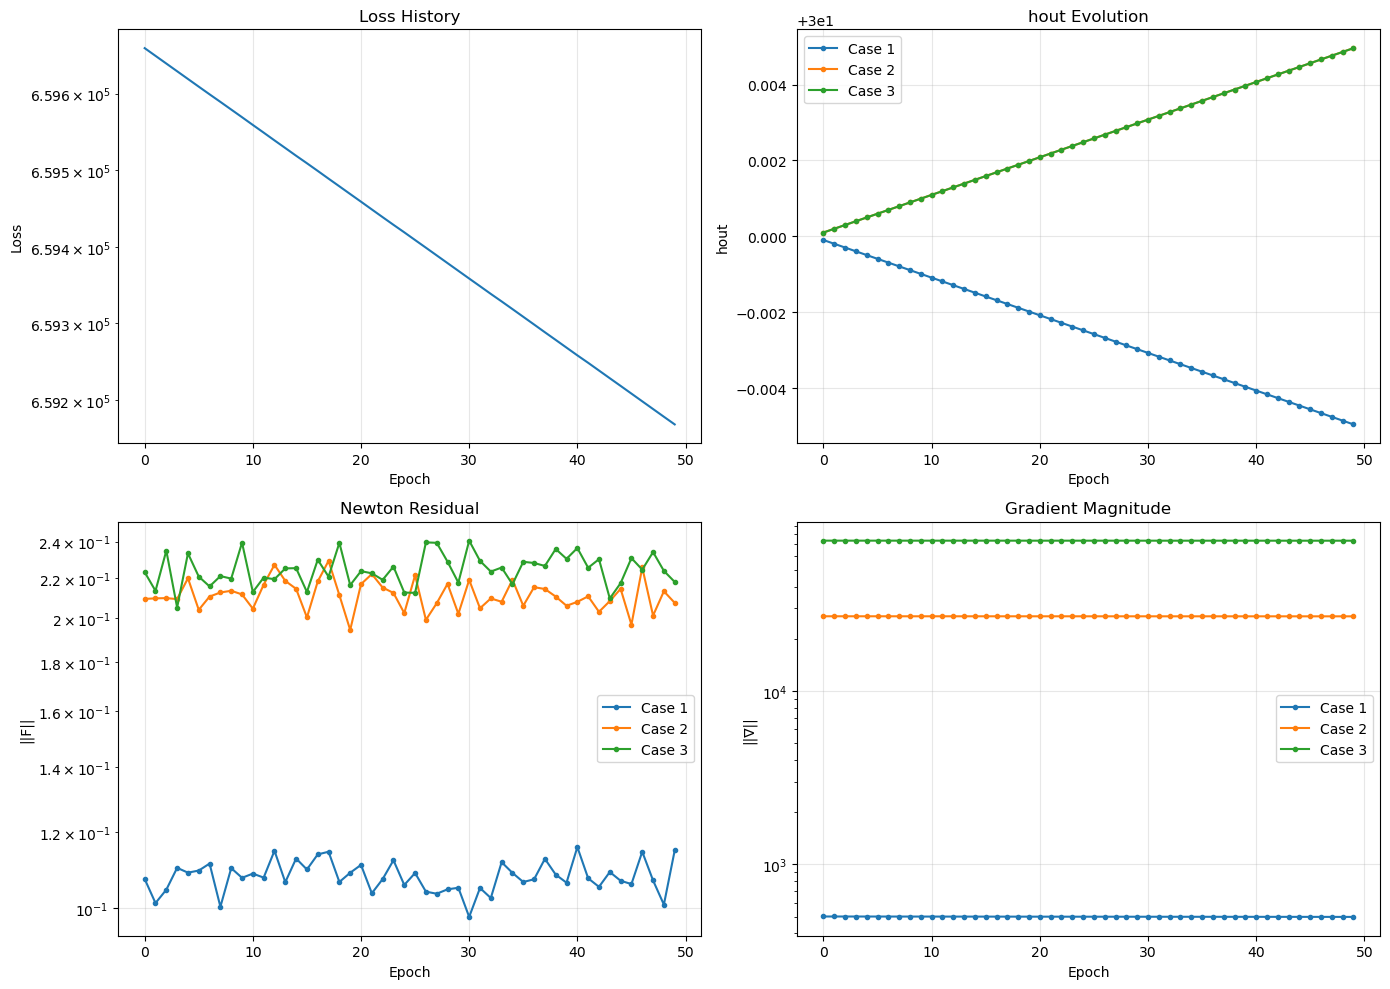

In [8]:
# 10) Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].semilogy(history['loss'])
axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss History'); axes[0, 0].grid(True, alpha=0.3)

# Parameters
params_array = np.array(history['params'])
for k in range(3):
    axes[0, 1].plot(params_array[:, k, 0], label=f'Case {k+1}', marker='o', markersize=3)
axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('hout')
axes[0, 1].set_title('hout Evolution'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)

# Newton convergence
newton_res = np.array(history['newton_res'])
for k in range(3):
    axes[1, 0].semilogy(newton_res[:, k], label=f'Case {k+1}', marker='o', markersize=3)
axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('||F||')
axes[1, 0].set_title('Newton Residual'); axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)

# Gradients
grads_array = np.array(history['grads'])
for k in range(3):
    grad_norm = np.linalg.norm(grads_array[:, k, :], axis=1)
    axes[1, 1].semilogy(grad_norm, label=f'Case {k+1}', marker='o', markersize=3)
axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('||∇||')
axes[1, 1].set_title('Gradient Magnitude'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()


FINAL RESULTS

케이스 1 (140.0W):
  파라미터: hout=29.995, hwi=50000.000, hwo=50000.000
  Newton:   ||F||=1.148e-01
  TC MSE:   3.431e+03


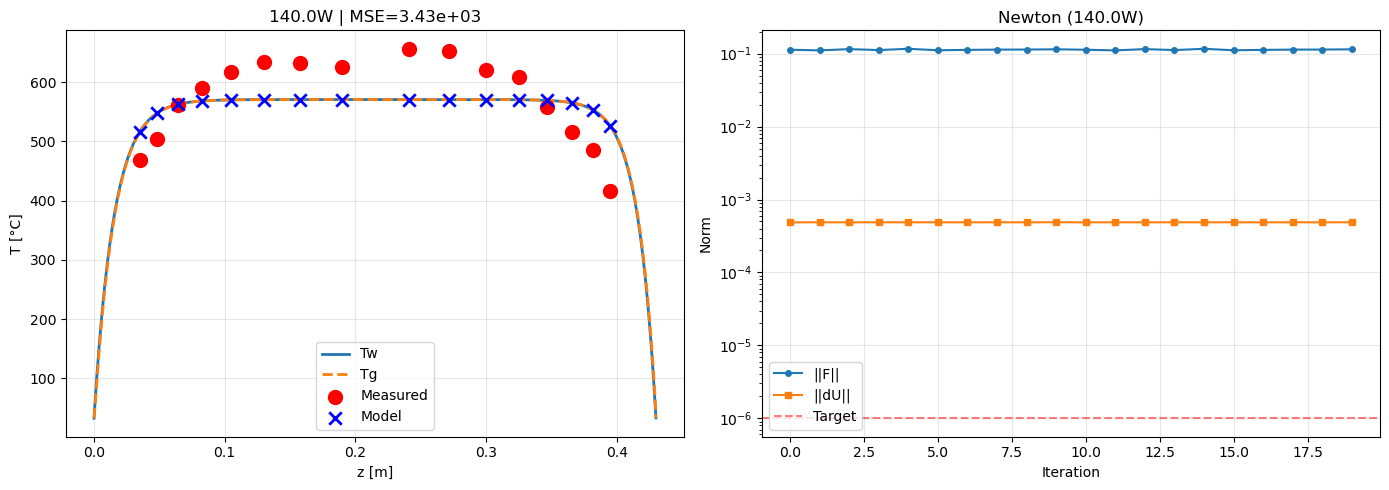


케이스 2 (280.0W):
  파라미터: hout=30.005, hwi=50000.000, hwo=50000.000
  Newton:   ||F||=2.073e-01
  TC MSE:   1.535e+05


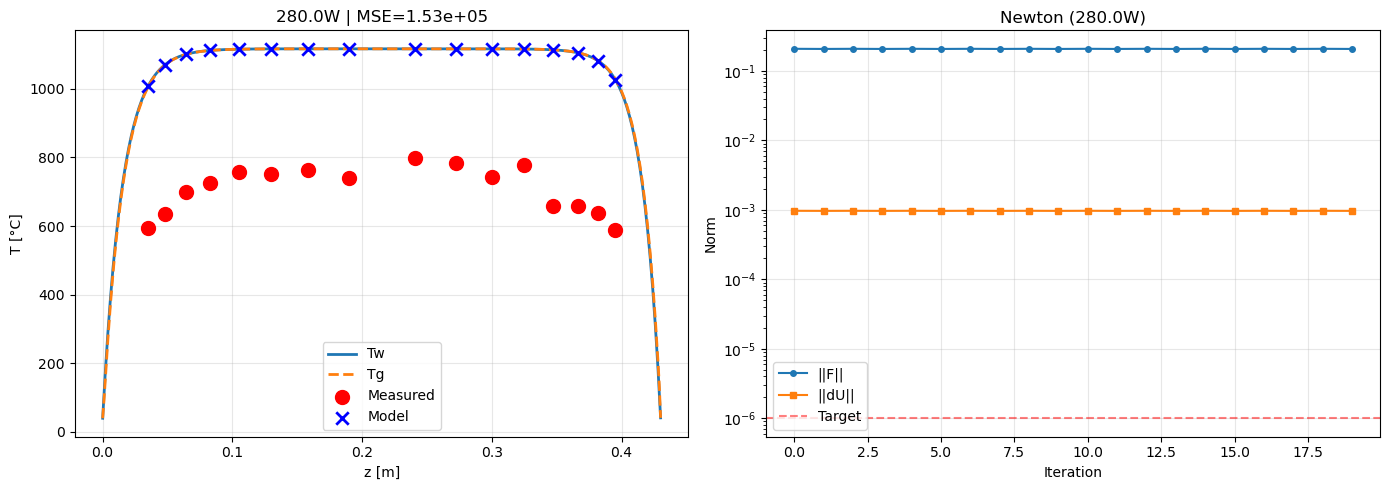


케이스 3 (420.0W):
  파라미터: hout=30.005, hwi=50000.000, hwo=50000.000
  Newton:   ||F||=2.414e-01
  TC MSE:   5.023e+05


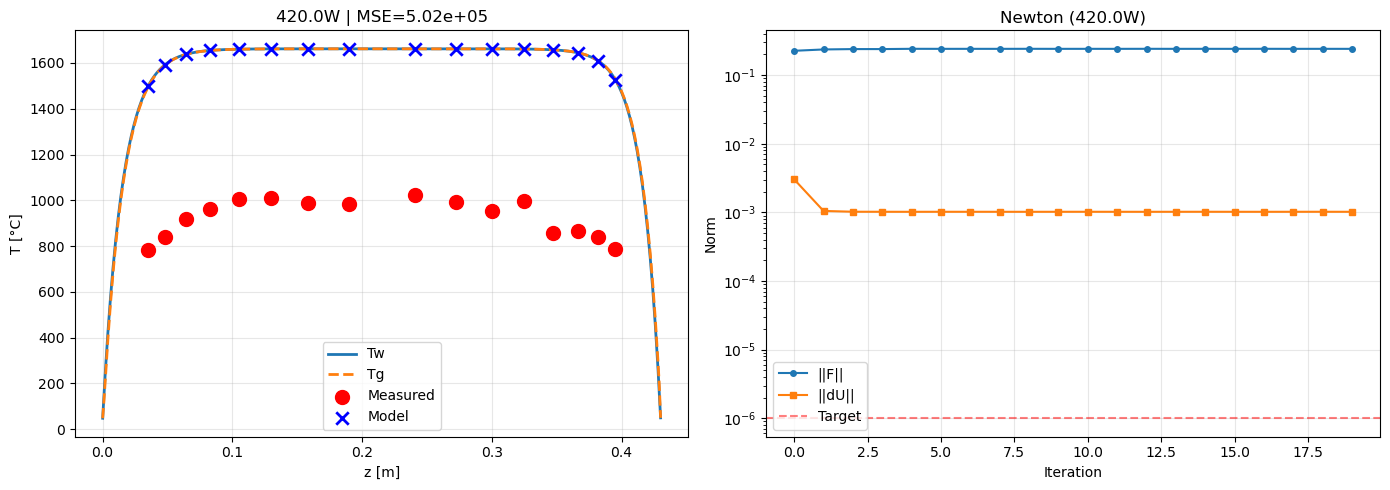

In [9]:
# 11) Final results
theta = theta_phys(theta_raw)

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)

for k, Pw_k in enumerate([140., 280., 420.]):
    coeffs = theta[k]
    res_fn = lambda U: residual(U, coeffs, Pw_k)
    U_star, res_hist, step_hist = newton_solve_forward(res_fn, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]; Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)
    mse = float(jnp.mean((Tw_tc - T_meas_cases[k])**2))
    
    print(f"\n케이스 {k+1} ({Pw_k}W):")
    print(f"  파라미터: hout={float(coeffs[0]):.3f}, hwi={float(coeffs[1]):.3f}, hwo={float(coeffs[2]):.3f}")
    print(f"  Newton:   ||F||={float(res_hist[-1]):.3e}")
    print(f"  TC MSE:   {mse:.3e}")
    
    # Temperature profile
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(np.array(z), np.array(Tw), label='Tw', linewidth=2)
    ax1.plot(np.array(z), np.array(Tg), label='Tg', linewidth=2, linestyle='--')
    ax1.scatter(np.array(tc_pos), np.array(T_meas_cases[k]), s=100, c='red', label='Measured', zorder=5)
    ax1.scatter(np.array(tc_pos), np.array(Tw_tc), s=80, c='blue', marker='x', linewidths=2, label='Model', zorder=5)
    ax1.set_title(f'{Pw_k}W | MSE={mse:.2e}', fontsize=12)
    ax1.legend(); ax1.set_xlabel('z [m]'); ax1.set_ylabel('T [°C]'); ax1.grid(True, alpha=0.3)
    
    ax2.semilogy(np.array(res_hist), label='||F||', marker='o', markersize=4)
    ax2.semilogy(np.array(step_hist), label='||dU||', marker='s', markersize=4)
    ax2.axhline(1e-6, color='r', linestyle='--', alpha=0.5, label='Target')
    ax2.set_title(f'Newton ({Pw_k}W)'); ax2.legend()
    ax2.set_xlabel('Iteration'); ax2.set_ylabel('Norm'); ax2.grid(True, alpha=0.3)
    
    plt.tight_layout(); plt.show()

print("\n" + "="*80)

In [10]:
# 12) Summary
print("\n" + "="*80)
print("진단 요약 (DIAGNOSTIC SUMMARY)")
print("="*80)

print("\n1. 방법론:")
print(f"   - Implicit Differentiation: {USE_IMPLICIT_DIFF}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - 경계값: {'Wide' if WIDE_BOUNDS else 'Narrow'}")

print("\n2. 학습 성능:")
loss_reduction = (1 - history['loss'][-1]/history['loss'][0]) * 100
print(f"   - Initial loss: {history['loss'][0]:.6e}")
print(f"   - Final loss:   {history['loss'][-1]:.6e}")
print(f"   - Reduction:    {loss_reduction:.2f}%")

print("\n3. Gradient 상태:")
final_grads = history['grads'][-1]
for k in range(3):
    grad_norm = np.linalg.norm(final_grads[k])
    status = "✅" if grad_norm > 1e-10 else "⚠️" if grad_norm > 1e-15 else "❌"
    print(f"   Case {k+1}: ||∇|| = {grad_norm:.3e} {status}")

print("\n4. Newton 수렴:")
final_newton = history['newton_res'][-1]
for k in range(3):
    status = "✅" if final_newton[k] < 1e-6 else "⚠️" if final_newton[k] < 1e-4 else "❌"
    print(f"   Case {k+1}: ||F|| = {final_newton[k]:.3e} {status}")

print("\n" + "="*80)
print("결론:")
print("="*80)

if USE_IMPLICIT_DIFF and loss_reduction > 10:
    print("✅ Implicit differentiation이 성공적으로 작동하고 있습니다!")
    print("   - Gradient 흐름: 정상")
    print("   - 메모리 사용량: 최소화")
    print("   - 학습 진행: 양호")
    if loss_reduction < 50:
        print("\n💡 추가 개선 제안:")
        print("   - epoch 수 증가 (50 → 200+)")
        print("   - learning rate 튜닝 실험")
elif not USE_IMPLICIT_DIFF:
    print("⚠️  stop_gradient 모드로 실행 중입니다.")
    print("   → USE_IMPLICIT_DIFF = True로 설정하여 재실행하세요!")
else:
    print("⚠️  학습이 충분히 진행되지 않았습니다.")
    print("   → Learning rate 증가 또는 초기값 조정 필요")

print("\n" + "="*80)


진단 요약 (DIAGNOSTIC SUMMARY)

1. 방법론:
   - Implicit Differentiation: True
   - Learning rate: 0.0001
   - 경계값: Wide

2. 학습 성능:
   - Initial loss: 6.596594e+05
   - Final loss:   6.591682e+05
   - Reduction:    0.07%

3. Gradient 상태:
   Case 1: ||∇|| = 4.976e+02 ✅
   Case 2: ||∇|| = 2.694e+04 ✅
   Case 3: ||∇|| = 7.356e+04 ✅

4. Newton 수렴:
   Case 1: ||F|| = 1.148e-01 ❌
   Case 2: ||F|| = 2.073e-01 ❌
   Case 3: ||F|| = 2.180e-01 ❌

결론:
⚠️  학습이 충분히 진행되지 않았습니다.
   → Learning rate 증가 또는 초기값 조정 필요

